In [8]:
import metaheuristics
import graph_handler
import fiduccia
import graph_handler 
import networkx as nx
import random
import math
import numpy as np
import time
import matplotlib.pyplot as plt
import pickle

In [9]:
def compareByFmPasses(passes = 10000, numberOfRunes = 20):

    graphInit = graph_handler.parse_graph("res/Graph500.txt", False)
    mlsCuts = []
    ilsCuts = []
    geneticCuts = []
    runTime = []
    for i in range(numberOfRunes):
        print(i)
        _, mlsCutsInOneRun, runTimeMLS = metaheuristics.mls(graphInit.copy(), maxFmPasses=passes)
        print("mls done")
        if passes:
            _,_,_, genCuts, runTimeGen = metaheuristics.geneticSearch(graphInit.copy(),  population=50, maxFmPass=passes )
        else: 
            _,_,_, genCuts, runTimeGen = metaheuristics.geneticSearch(graphInit.copy(), maxTime=runTimeMLS, population=50)
        print("genetic done")
        
        if passes:
            _,ilsCutsInOneRun, _, runTimeILS,_ = metaheuristics.ils(graphInit.copy(),startNumberOfMutations=105,  maxFmPasses=passes)
        else: 
            _,ilsCutsInOneRun, _, runTimeILS,_ = metaheuristics.ils(graphInit.copy(),startNumberOfMutations=105,  maxTime=runTimeMLS)
            
        print("ils done")
     
        mlsCuts.append({"cuts": mlsCutsInOneRun, "time": runTimeMLS})
        ilsCuts.append({"cuts": ilsCutsInOneRun,"time": runTimeILS})
        geneticCuts.append({"cuts": genCuts, "time": runTimeGen})
        if passes:
            pickle.dump(mlsCuts, open(f"res/results/mls_runs_{numberOfRunes}_passes_{passes}.p", "wb"))
            pickle.dump(geneticCuts, open(f"res/results/genetic_runs_{numberOfRunes}_passes_{passes}.p", "wb"))
            pickle.dump(ilsCuts, open(f"res/results/ils_runs_{numberOfRunes}_passes_{passes}.p", "wb"))

        else:
            pickle.dump(mlsCuts, open(f"res/results/mls_runs_{numberOfRunes}_time.p", "wb"))
            pickle.dump(geneticCuts, open(f"res/results/genetic_runs_{numberOfRunes}_time.p", "wb"))
            pickle.dump(ilsCuts, open(f"res/results/ils_runs_{numberOfRunes}_time.p", "wb"))

    return mlsCuts, ilsCuts, geneticCuts


#print(graph_handler.getStringBinaryRepresentation(graphInit))


In [10]:
def runMutationExperiment(maxFmPass = 10000, numberRuns = 20, mutations = [2,4,6,8,10]):
    G = graph_handler.parse_graph("res/Graph500.txt", False)
    mut = 0
    partition = metaheuristics.createRandomPartition(G)
    res = {}
    # res = mutation size : { run : cuts for one ils run } with 0<=runs<20 and cuts for one ils run =  [fm_seach_1_cuts, fm_seach_2_cuts, ...]
    

    for mut in mutations:
        print(mut)

        res[mut] = {}
        for i in range(numberRuns):
            _,cutsOneRun,_,t, cntNotImproved = metaheuristics.ils(G.copy(), maxFmPasses=maxFmPass,startNumberOfMutations = mut, partition = partition)
            res[mut][i] = {"cuts" : cutsOneRun, "cntNotImproved" : cntNotImproved, "time": t}


        pickle.dump(res, open(f"res/results/mutations_runs_{numberRuns}_passes_{maxFmPass}_sad.p", "wb"))

In [12]:
print("mutation")
runMutationExperiment(10000, 20, mutations= [15,45,75,105, 135 ] )
print(" by passes")
compareByFmPasses(passes= 10000 , numberOfRunes= 20)
print("by time")
compareByFmPasses( numberOfRunes= 25)


 by passes


In [13]:
def getTimePerRun(res):
    timePerRun = []
    
    for run in res:
        timePerRun.append(run["time"])
    return timePerRun

In [14]:
def getCutsPerRun(allCuts):
    cutsPerRun = []
    for run in allCuts:
        cutsPerFm = []
        for fmsearch in run["cuts"]:
            for fmpass in fmsearch:
                cutsPerFm.append(fmpass)
        cutsPerRun.append(cutsPerFm)
    return cutsPerRun

In [15]:
def getMinsOverRuns(cuts):
    mins = []
    for run in cuts:
        mins.append(min(run))
    globalMin = min(mins)
    numberOfmins = 0
    for run in cuts:
        for cut in run:
            if cut == globalMin:
                numberOfmins =+ 1
    return mins, numberOfmins

In [16]:
def getAvgsAndStd(all_cuts):
    avg = []

    for k in range(10000):
        sum = 0
        cnt = 0        
        for i in range(20):
            if len(all_cuts[i]) > k:
                sum += all_cuts[i][k]
                cnt += 1
        if cnt > 0:
            avg.append(sum/cnt)

    std = []
    for k in range(10000):
        std_sum = 0
        cnt = 0        
        for i in range(20):
            if len(all_cuts[i]) > k:
                
                std_sum += (avg[k] - all_cuts[i][k]) ** 2
                
                cnt += 1
        if cnt > 0:
            std.append(math.sqrt(std_sum/cnt))
    return avg, std
    

In [17]:
def createPlot(avg_list, std_list, name=None, lim=None):
    fig, ax = plt.subplots()
    ax.fill_between(range(len(avg_list)), np.array(avg_list) + np.array(std_list), np.array(avg_list) - np.array(std_list), alpha=.5, linewidth=0)
    plt.plot(avg_list)
    plt.ylabel('average cutsize')
    plt.legend()
    plt.xlabel('fm-pass')
    if lim:
        plt.ylim(lim)
    else:
        plt.ylim(0, max(avg_list) + 20)
    if name:
        plt.savefig(f"res/results/{name}_perfm.png")
    plt.show()


In [18]:
def getPerfectGraph():
    graphInit = graph_handler.parse_graph("res/Graph500.txt", False)
    minCut = math.inf
    while minCut > 2:
        _,_,best, genCuts, runTimeGen = metaheuristics.geneticSearch(graphInit.copy(),  population=50, maxFmPass=10000 )
        minCut = genCuts[-1][-1]
        print(minCut)
    #print(best)
    graph_handler.setPartitionByBinaryList(graphInit, best)
    return graphInit



In [19]:
gr = pickle.load(open("res/results/graph_two_cuts.p", "rb"))

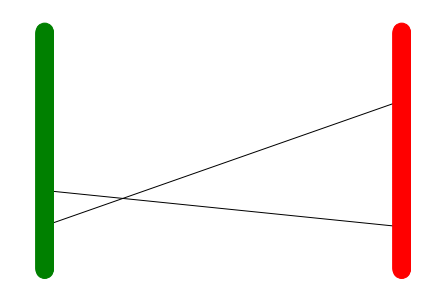

In [20]:
plt.figure(figsize=(6,4))
#graph_handler.vizualize_graph(G)
partion = graph_handler.getPartition(gr)
pos = nx.bipartite_layout(gr, partion)
color_map = [gr.nodes[node]['color'] for node in gr]   
    
nx.draw(gr, pos, with_labels=False,node_color=color_map)
    

In [41]:
mutations_res = pickle.load( open("res/results/mutations_runs_2_passes_10000_sad.p", "rb"))


In [37]:
mutation_cuts = {}
for mut_size, res in mutations_res.items():
    mutation_cuts[mut_size] = getCutsPerRun(list(res.values()))

In [38]:
mutations_mins = {}

for mut_size, res in mutation_cuts.items():
    mutations_mins[mut_size],_ = getMinsOverRuns(res)


In [47]:
mutations_not_improved = {}
for mut_size, res in mutations_res.items():
    mutations_not_improved[mut_size] = []
    for run, value in res.items():
        
        mutations_not_improved[mut_size].append(value["cntNotImproved"]) 

Text(17.5, 0.5, 'not improved counter')

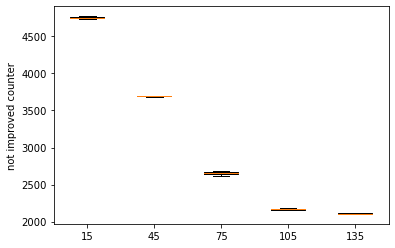

In [50]:
plt.boxplot(mutations_not_improved.values(), labels=mutations_not_improved.keys())
plt.savefig("res/results/boxplotcomparison_ils")
plt.ylabel("not improved counter")

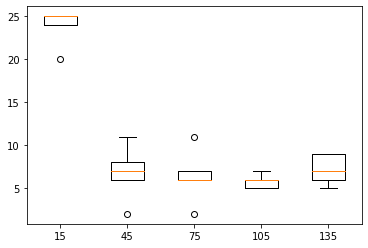

In [40]:
plt.boxplot(mutations_mins.values(), labels=mutations_mins.keys())
plt.savefig("res/results/boxplotcomparison_ils")
plt.ylabel("cutsize")

In [26]:
all_mls_cuts = pickle.load(open("res/results/mls_runs_20_passes_10000.p", "rb"))
#all_ils_cuts = pickle.load(open("res/results/ils.p", "rb"))
all_cuts_gen = pickle.load(open("res/results/genetic_runs_20_passes_10000.p", "rb"))
mls_cuts = getCutsPerRun(all_mls_cuts)
gen_cuts = getCutsPerRun(all_cuts_gen)
min_mls_cuts, mls_number_mins_reached = getMinsOverRuns(mls_cuts)
#min_ils_cuts = [x[-1] for x in all_ils_cuts]
min_gen_cuts, gen_number_mins_reached = getMinsOverRuns(gen_cuts)
print(min_gen_cuts)
print(min(min_gen_cuts))
print(min_gen_cuts.count(min(min_gen_cuts)))
print(np.mean(min_gen_cuts))
print(np.std(min_gen_cuts))

[7, 9, 3, 6, 2, 2, 7, 5, 2, 7, 3, 3, 2, 5, 6, 4, 5, 3, 7, 3]
2
4
4.55
2.0850659461993044


In [27]:
mls_times = getTimePerRun(all_cuts_gen)
print(np.mean(mls_times))
print(np.std(mls_times))

111.32036854028702
12.26840025523201


In [28]:
mls_cuts = getCutsPerRun(all_mls_cuts)
gen_cuts = getCutsPerRun(all_cuts_gen)
min_mls_cuts, mls_number_mins_reached = getMinsOverRuns(mls_cuts)
#min_ils_cuts = [x[-1] for x in all_ils_cuts]
min_gen_cuts, gen_number_mins_reached = getMinsOverRuns(gen_cuts)

In [29]:
#ils_avg, ils_std = getAvgsAndStd(all_ils_cuts)
mls_avg, mls_std = getAvgsAndStd(mls_cuts)
gen_avg, gen_std = getAvgsAndStd(gen_cuts)

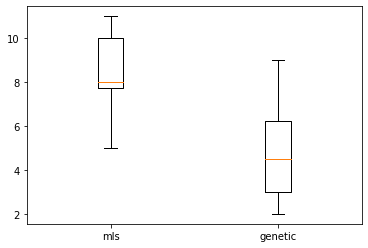

In [30]:
plt.boxplot([min_mls_cuts,  min_gen_cuts], labels=["mls", "genetic"])
plt.savefig("res/results/boxplotcomparison")


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


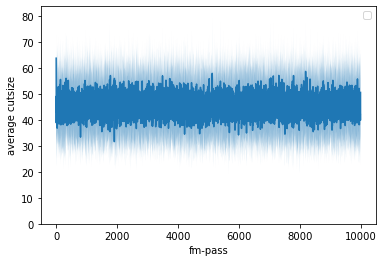

In [31]:
createPlot(mls_avg, mls_std, "mls")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


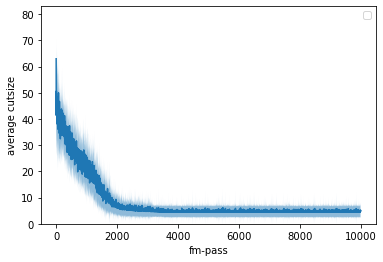

In [32]:
createPlot(gen_avg, gen_std, "gen")